# Processing passive seismic data

This notebook deals with reading, writing and basic processing passive seismic data using [ObsPy](https://docs.obspy.org/).

## It is intended to be run in Colab.


#### Dependencies: Obspy, Numpy, Matplotlib

#### Reset the Jupyter/IPython notebook in order to run it again, press:
***Kernel*** -> ***Restart & Clear Output***

---
## Install Conda and create an *environment*, and install the required *packages* for the work.

* The `condacolab` commands need to be run as the first Code cell!
* After `condacolab.install()`, the Python kernel will be restarted.
* Do not use the `Run all` option. Run the `condacolab` cell _individually_ and wait for the kernel to restart.
* You can only use the `base` environment. Do not try to create new ones; instead update `base` with either:
  * `conda install <packages>`
  * `conda env update -n base -f environment.yml`

## ***Attn:*** Every time you quit or reset the runtime, you wil need to install Conda again.

In [1]:
# Import and install condacolab python library.
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
#------------  RESTART kernel HERE!  ------------
# Remove the pip installation of ObsPy for sanity reasons.
#!pip uninstall obspy -y
import condacolab
condacolab.check()
!conda init bash

✨🍰✨ Everything looks OK!
no change     /usr/local/condabin/conda
no change     /usr/local/bin/conda
no change     /usr/local/bin/conda-env
no change     /usr/local/bin/activate
no change     /usr/local/bin/deactivate
no change     /usr/local/etc/profile.d/conda.sh
no change     /usr/local/etc/fish/conf.d/conda.fish
no change     /usr/local/shell/condabin/Conda.psm1
no change     /usr/local/shell/condabin/conda-hook.ps1
no change     /usr/local/lib/python3.10/site-packages/xontrib/conda.xsh
no change     /usr/local/etc/profile.d/conda.csh
no change     /root/.bashrc
No action taken.


In [3]:
# Verify the Conda installation. Update.
!conda update -n base -c conda-forge conda --yes
!conda --version

# Option not used: Create environment.yml
#!printf "\n channels: \n   - defaults \n   - conda-forge \n dependencies: \n   - python>=3.12.5 \n   - cartopy \n   - pip \n   - pip: \n     - numpy>=1.15.0 \n     - scipy>=1.4.0 \n     - matplotlib \n     - seaborn \n     - obspy \n     - jupyterlab \n     - pandas \n     - pyqt5 \n     - pyrocko \n     - utm \n     - segyio \n" >> environment.yml
#!cat environment.yml
#!conda env update -n base -f environment.yml

# Create base environment
!conda create -n base python=>3.9 -y

# Locate the Conda package. Verify the Conda installation.
!conda info
!which conda

# Create a new conda environment
!conda create -n pSeis python=>3.9 -y

# Activate the environment
!conda activate pSeis

!python -m ipykernel install --user --name pSeis --display-name "pSeis"

!conda env list

# Install needed packages
# obspy>=3.8 numpy>=1.15.0 scipy>=1.4.0
!conda install -c conda-forge pandas numpy matplotlib numpy scipy utm segyio collections
# Install the certifi package, which is a dependency of the cartopy package, that obspy depends on.
!conda install -c conda-forge certifi cartopy
!conda install -c conda-forge obspy

#sanity
try:
    import obspy
except:
    !pip install obspy

# Import specialized ObsPy packages. Sanity.
try:
    import obspy
    print('obspy version==>', obspy.__version__)
except TypeError:
    print('Stopping RUNTIME. If run for the first time Colab should be restarted. Run again.')
    exit()

from obspy import read
from obspy import UTCDateTime
from obspy import read, Stream

# matplotlib magic command for Colab
%matplotlib inline
# matplotlib magic command for local Notebook
#%matplotlib notebook
# Import matplotlib and alias it as 'plt'
from matplotlib import pyplot as plt

!echo "Conda environment has been created!"


Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.8.30  |       hbcca054_0         155 KB  conda-forge
    certifi-2024.8.30          |     pyhd8ed1ab_0         160 KB  conda-forge
    libgcc-14.1.0              |       h77fa898_1         827 KB  conda-forge
    libgcc-ng-14.1.0           |       h69a702a_1          51 KB  conda-forge
    libgomp-14.1.0             |       h77fa898_1         449 KB  conda-forge
    openssl-3.3.2              |       hb9d3cd8_0         2.8 MB  conda-forge
    ---------------

---
## Accessing a local data

This lecture serves as a basic introduction to using Obspy. Useful links are the official [Obspy Tutorial](https://docs.obspy.org/tutorial/index.html), and the [Seismo-Live Juypter Notebooks for Seismology](https://krischer.github.io/seismo_live_build/tree/index.html).

We work with data form an event occured in Acre in 2024, downloaded using [IRIS Wilber](http://www.iris.edu/wilber3).

|EventID | Time | Lat | Long | Depth(km) | Mww | Location |
| :- | :-: | :- | :- | :-: | :-: | :- |
|11793085|2024-01-20T21:31|-7.2879|-71.464|607|6.6|WESTERN BRAZIL|

We will use a data file in miniSEED format: [wb11793085_ir.mseed](https://github.com/jandyr/ProSeisSN_Nbk/blob/main/wb11793085_ir.mseed).

Choose stations with epicentral distances $\left[20^{\circ},\,70^{\circ}\right]$; waves travel in the laterally homogeneous Mantle, with P and S arrivals.

Of the 149 stations operational during the event, select station IU HKT, distant $44^{\circ}$ from the event.

|Station|Seismometer| Lat | Long | Depth(m) | Channels |
| :- | :- | :- | :- | :-: | :-: |
|HKT: Hockley1 Texas|Streckeisen STS-6A VBB |29.96|-95.84|93|BH1, BH2, BHZ|

**Phase Arrivals**

|Phase|$\Delta t$| TIme |
| :- | :-: | :- |
|P|+7m 14s|21:38:19|
|PP|+9m 9s |21:40:14|
|S|+13m 4s|21:44:09|
|SS|+16m 38s|21:47:43|

To upload data files directly click on the data explorer icon (in red)
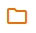
 and select the “upload” option (with the upward arrow)
image.png.

Otherwise retrieve data files from the cloud.

In [10]:
!ls
st = read('sample_data/wb11793085.mseed')
print(st)

3.9  condacolab_install.log  sample_data


TypeError: Unknown format for file sample_data/wb11793085.mseed

**st** is a stream object, which contains the data and associated metadata. The data are collections of trace objects.

In [ ]:
# Read a trace from the stream object.
tr = st[2]
print(tr)
# Print the trace data content; a numpy array.
print(tr.data)
# Print the trace metadata
print(tr.stats)

Any of the metadata content can be assessed through, e.g., **tr.stats.npts**.

Plot the trace.

In [ ]:
st[0:3].plot();

In [ ]:
# matplotlib magic command for Colab
%matplotlib inline
# matplotlib magic command for local Notebook
#%matplotlib notebook

# Import matplotlib and alias it as 'plt'
from matplotlib import pyplot as plt
%matplotlib notebook

# Construct a figure for BHZ trace
fig, ax = plt.subplots()
_ = st[2].spectrogram(log=True, dbscale=True, axes=ax, show=True, cmap = "jet")

plt.show()

## First steps in data processing

### 1) To construct a figure to plot we need to import **matplotlib**.

### 2) Spectrogram
The spectrogram shows the waveform frequency content [spectrogram](https://docs.obspy.org/tutorial/code_snippets/plotting_spectrograms.html).

The spectrogram shows the power in each frequency band (y-axis) for every few samples in time (x-axis). Warmer colours indicate more power.

In general terms earthquakes emit a broad range of frequencies, but as higher frequencies attenuate faster $f > 20$Hz attenuate a great deal for earthquakes recorded beyond a few km away.

## 3) Filtering
**ObsPy** has several [filters](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.filter.html).:
- "bandpass" filters *retain* a frequency range $\Delta f=\left[f_{1},f_{2}\right]=f_{1}\leq\Delta f\leq f_{2}$;
- "lowpass" filters *retain* the frequency range $\Delta f\leq f_{cutoff}$;
- "highpass" filters *retain* the frequency range $\Delta f\geq f_{cutoff}$;
- "notch" filters *remove* the frequency range $f_{1}\leq\Delta f\leq f_{2}$, therefore does the *opposite* of bandpass.



In [ ]:
# Import obspy Stream
from obspy import Stream

# BHZ trace. Check.
# Read a trace from the stream object.
tr = st[2]
print(tr.stats.channel)
tr.plot()

# corners=filter order; zerophase=True, results in a zero phase shift.
#tr.filter("highpass", freq=6.)
tr.filter("bandpass", freqmin=6., freqmax=11.)

# Plot filtered trace
tr.plot(color = 'blue');

# Plot spectograms
fig, ax = plt.subplots()
_ = tr.spectrogram(log=True, dbscale=True, axes=ax, show=True, cmap = "jet")

In [ ]:
# Import ObsPy UTCDateTime class
from obspy import UTCDateTime

# Specify start and end times
starttime = UTCDateTime("2024-01-20T21:37:19.019539Z") - 60
endtime = UTCDateTime("2024-01-20T21:58:18.994539Z")
print(starttime, endtime)

## 4) Removing the instrument response

The trace shown in blue above does not represent the actual ground motion at station **HKT**, but it is in digital *counts*, to be read by a computer. Those counts were digitized from the *analog* voltage signal that is necessary to keep the mass inside the instrument stable when the ground is moving; an *electromagnetic* negative feedback device[IRIS](https://www.iris.edu).

To convert *counts* to ground velocity we need to remove the **digitizer and the response of the seismometer** itself; a function of frequency. We will use **Obspy** for that, but we will need the *instrument response*, which is not in the data file [2024-01-20-mww66-western-brazil.miniseed](https://github.com/jandyr/ProSeisSN/tree/main/Unit01/Expositive).

### 4.1. UTCDateTime objects

**Obspy** manages the downloading and handling data using [UTCDateTime objects](https://docs.obspy.org/tutorial/code_snippets/utc_date_time.html). It is a Python string

**YYYY-MM-DDTHH:MM:SS**,

with the origin time of an earthquake, or the start of the time period to download the data.

We know the metadata from the event occured in Acre in 2024, downloaded using [IRIS Wilber](http://www.iris.edu/wilber3). We have downloaded the data starting 1min before the **P** arrival time.







###4.2. Specify station

We need to provide: network, station, location, and channels:

__Network code__: Identifies the [network](http://ds.iris.edu/mda/) assigned by the FDSN.

__Station code__: The station within a network.

__Location ID__: Stations can have more than one instrument, which is specified by the location ID.

__Channel codes__: A three character channel code.

Specify [IRIS](https://docs.obspy.org/packages/obspy.clients.fdsn.html) as a client of the [FDSN (International Federation of Digital Seismograph Networks)](https://www.fdsn.org/about/).

In [ ]:
# Import ObsPy Client class
from obspy.clients.fdsn import Client

# Specify client
client = Client("IRIS")

_(i)  Provide: network, station, location, and channels_

_(ii) Use **Obspy** function: **get_waveforms**_

In [ ]:
# Use wildcards to select all three HH channels
net = "IU"
sta = "HKT"
loc = "00"
chan = "HH*"

# Get waveforms with instrument response into a stream
st = client.get_waveforms(net, sta, loc, chan, starttime, endtime, attach_response = True)
print(st)
st.plot();

###4.3. Remove the instrument response

_(i)  Make a *deep* copy of the original stream as the function **remove_response** acts on the data, overwriting the original stream._

_(ii) Express the ground motion in velocity, **output = 'VEL'**, in units of velocity (m/s)._

The process involves multiplication with the inverse of the instrument response, which usually attain small numerical values at both frequency ends. This results in the signal+noise being multiplied by relatively large numbers, making noise contribution large. This can be alleviated by tapering the signal or imposing a *cap* to the inverse of the instrument response.

_Caution:_ If you run the code below more than once the function **remove_response** will corrupt the data because the original stream is lost. Use the copy of the original stream if needed.

In [ ]:
# Deep copy of the original stream
st_0 = st.copy()

# Remove the instrument response of all components. Other options: output = 'DISP', 'ACC'
st.remove_response(output = 'VEL')

# Plot only Z component (the last trace in stream).
# Make a deep copy of it as remove_response acts on the data, overwriting it
dummy = st_0[-1].copy()
dummy.remove_response(output = 'VEL', plot = True)

st_0[-1].plot()
dummy.plot(color = 'blue');

###4.4. Save the corrected data

Save the data with the instrument response removed for further work, in the same directory as this Jupyter notebook.

_Save the data in miniSEED_ specifying file path, name, extension, and data format:

**stream.write('/path/filename.mseed', format='MSEED')**.

In [ ]:
# Save it with event code in the name (wb=western-brazil, ir=nstrument response removed)
filename = 'wb11793085' + '_ir' + '.mseed'
dummy = input(f'>> Save instrument corrected data '+filename+' (rtn = No): \n') or False
if not dummy:
    st.write(filename, format='MSEED')

# Check Z component
dummy = read(filename)
print(dummy[-1].stats)